# Solubility prediction for organic chemicals

Aqueous solubility is one of the key parameters defining a molecular drug activity.

In this notebook, we will develop models to predict the solubility of organic molecules in water based on their physiochemical
properties. 

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

The data was taken from the database created by Schaper and Raevskaja:
https://doi.org/10.1021/ci400692n

In [32]:
solubility=pd.read_excel(r'solubility.xlsx')

In [33]:
solubility.head()

,Formula,name,Molecular weight,S(g/L),S(M/L),"Tmp, C",pK1,pK2,pK3,f(ui),logS,logP
0,CC(C)(C)CO,"NEOPENTYL ALCOHOL; 2,2-DIMETHYL-1-PROPANOL",88.150,35.10,0.398,56.0,NaN,NaN,NaN,1.0,-0.40,1.108
1,CN=C=S,METHYL ISOTHIOCYANATE,73.119,7.31,0.100,35.0,NaN,NaN,NaN,1.0,-1.00,1.013
2,C1OCOCO1,"1,3,5-TRIOXANE",90.079,176.00,1.950,64.0,NaN,NaN,NaN,1.0,0.29,-0.446
3,CC(N)=O,ACETAMIDE,59.068,2250.00,38.000,80.0,NaN,NaN,NaN,1.0,1.58,-0.832
4,CC(O)CNCC(C)O,BIS(2-HYDROXYPROPYL)AMINE,133.191,860.00,6.460,44.5,8.97,NaN,NaN,1.0,0.81,-0.540


In [34]:
solubility.shape

(2615, 12)

In [35]:
solubility.columns

Index(['Formula', 'name', 'Molecular weight', 'S(g/L)', 'S(M/L)', 'Tmp, C',
       'pK1', 'pK2', 'pK3', 'f(ui)', 'logS', 'logP'],
      dtype='object')

The data contains the following columns:
    
   **Formula**  contains a Simplified Molecular Input Line Entry System,” which is used to translate a\
   chemical's three-    dimensional structure into a string of symbols;\
   **name** is the IUPAC name of the compound;\
   **Molecular wight** contains molecular weight of a molecule;\
   **S(g/L)** is a solubility in grams per liter;\
   **S(M/L)** is a solubility in mole per liter;\
   **logS** is the natural logarithm of molar solubility;\
   **Tmp, C** is the temperature of the melting point of a substance;\
   **logP** is the value of octanol–water partition coefficient;\
   **pK1**, **pK2** and **pK3** are -log of corresponding constants of dissociation;\
   **f(ui)** - fraction un-ionized;\

In [36]:
solubility.dtypes

Formula              object
name                 object
Molecular weight    float64
S(g/L)              float64
S(M/L)              float64
Tmp, C              float64
pK1                 float64
pK2                 float64
pK3                 float64
f(ui)               float64
logS                float64
logP                float64
dtype: object

Most of the variables are floats except for the chemical formula and chemical name.

## Target variable : solubility

In this project, we will use some physiochemical properties of molecules to predict their solubility in water.

The dataset contains solubility values in g/L, Mol/L, log Sexp, and log Suni : columns **S(g/L)**, **S(M/L)**,  and 
    **logS**.
    
Let us take a look at these columns.

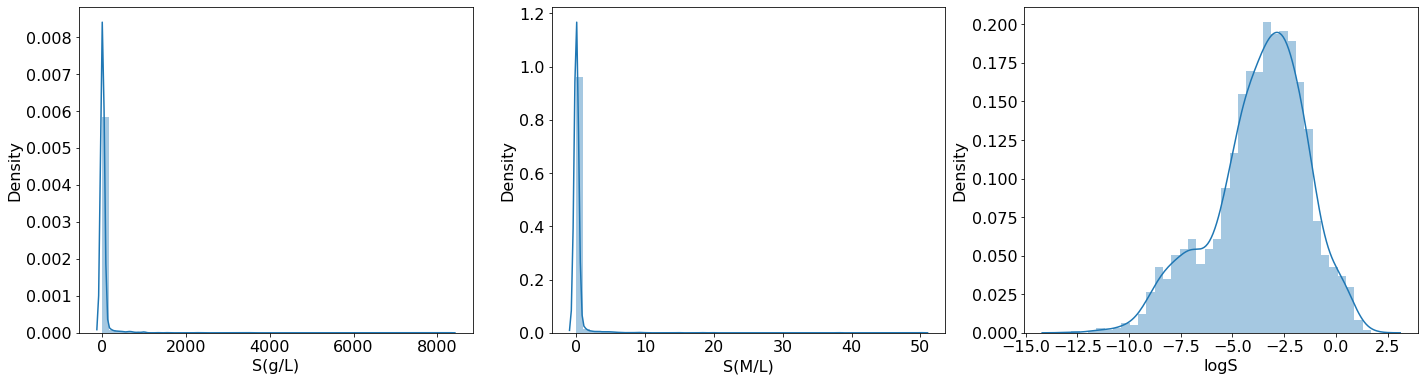

In [37]:
plt.figure(figsize=(24,6)) 
plt.rc('font', size=16)
plt.subplot(131)
sns.distplot(solubility['S(g/L)'])
plt.subplot(132)
sns.distplot(solubility['S(M/L)'])
plt.subplot(133)
sns.distplot(solubility['logS'])
plt.show()

We can see that the distributions of the absolute value of solubility ( in g/L and M/L) are not normal.
We will use the logarithmic solubility (logS) as the target variable as its distribution is closer than normal as compared to
the distributions of the absolute solubility values.

It's generally accepted that the substances with logS greater than -5 are considered to be soluble in water and the sabstances with logS lower than -5 are considered to be insoluble.

Let's create a  variable **soluble** that will indicate weather a molecule is considered to be soluble or insoluble in water accoridng to this criteria. The variable will be equal to 1 for soluble molecules and 0 for insoluble molecules.

Ww will use this variable as the target variable for our predictive models.

In [38]:
condition=(solubility['logS']>=-5)
solubility['soluble']=np.where(condition,1,0)

In [39]:
solubility['soluble'].value_counts()

1    1980
0     635
Name: soluble, dtype: int64

Our dataset contains 1980 molecules that are soluble in water and 635 molecules that are insoluble.

Let us visualise physiochemical properties present in the data set.

## Visualization of physiochemical properties

### Molecular weight

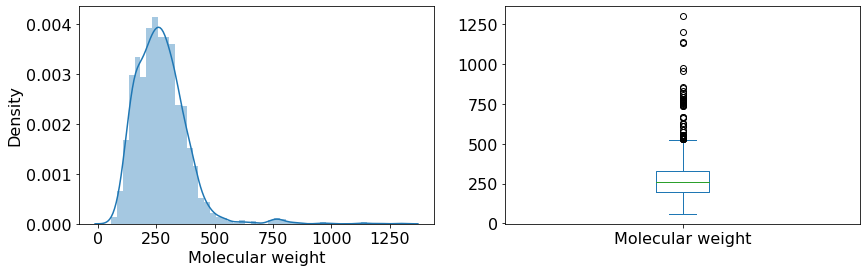

In [40]:
plt.figure(1)
plt.subplot(121)
sns.distplot(solubility['Molecular weight'])
plt.subplot(122)
solubility['Molecular weight'].plot.box(figsize=(14,4))
plt.show()

The distribution of the molecular weights is right skewed.

### Melting point (Tmp, C)

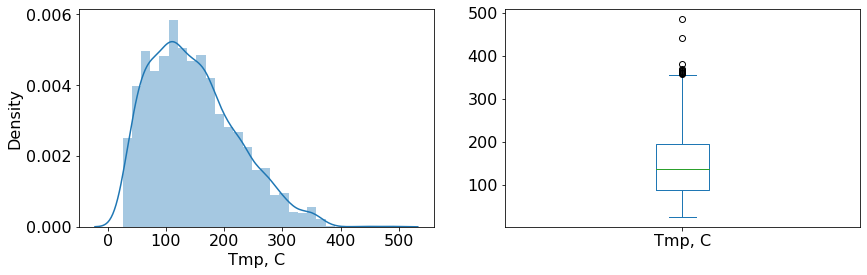

In [41]:
plt.figure(1)
plt.subplot(121)
sns.distplot(solubility['Tmp, C'])
plt.subplot(122)
solubility['Tmp, C'].plot.box(figsize=(14,4))
plt.show()

The distribution of the melting point temperatures is right-skewed.

### Octanol-water partitioning coefficient

The octanol-water partitioning coefficient (P) describes the distribution of the substance between aqueous (polar) and 
n-octanol (non-polar) solvents and is defined by the relation of the substance concentration in water and in n-octanol.

Let us visualize the natural logarithm of the partitioning coefficient (log(P)) of the substances in our data set.

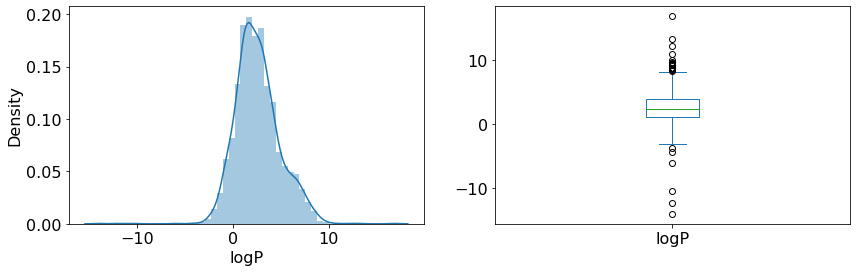

In [42]:
plt.figure(1)
plt.subplot(121)
sns.distplot(solubility['logP'])
plt.subplot(122)
solubility['logP'].plot.box(figsize=(14,4))
plt.show()

The distribution of octanol-water partitioning coefficients is not normal.

### Dissociation constants

Dissociation constant (K) define the extent to which a molecule can dissciate into ions in water.
K1 is the constant for the first step dissociation from neutral molecule to one cation and one anion.
K2 is the constant for the second step dissociation from an ion formed in the first step to another cation and anion.
K3 is the constant for the third step dissociation.

pK1, pK2 and pK3 are the negative logarithms of the dissociation constants (pK=-logK).

Most of the molecule have only one step of dissociation.
Let us visualize the distributions of the constants.

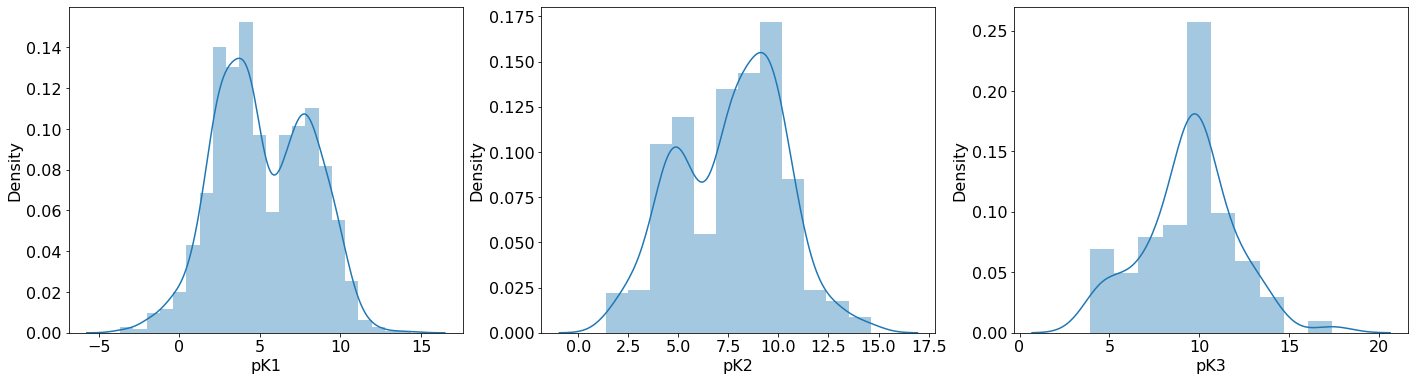

In [43]:
plt.figure(figsize=(24,6)) 
plt.rc('font', size=16)
plt.subplot(131)
sns.distplot(solubility['pK1'])
plt.subplot(132)
sns.distplot(solubility['pK2'])
plt.subplot(133)
sns.distplot(solubility['pK3'])
plt.show()

The distributions of dissociation constant are not normal.

### Un-ionized fraction

Text(0.5, 0, 'f(ui)')

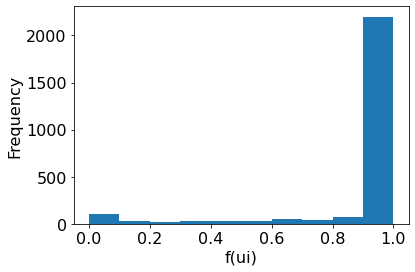

In [44]:
solubility['f(ui)'].plot(kind='hist')
plt.xlabel('f(ui)')

For most of the molecules f(ui)=1 (the un-ionized fraction = 1) so they are entirely in un-ionized form.

## Solubility vs. physiochemical properties

## Hypothesis stetement

We can make several hypothesis about the relationship between certain physiochemical qualities of a substance with
the substance solubility in water. For example:
    
1.There should be a relationship between the octanol-water partinioning coefficient and the solubility of a substance.
  Because one can assume that the higher is the solubility in water, the higher fraction of a sabstance would be in water
  rather than in organic octanol. And the higher the fraction in octanol the lower should be the solubility in water.
  So the higher is the partitioning coefficient the lower is the solubility.
  
2.A volume-related term (molecular polarizability α) was experimentally found to have an essential negative contribution 
  to solubility. The lower polarizability the higher solubility in polar water.
 
3.Water is a polar solvent so one can assume that the higher unionized fraction f(ui) the lower solubility in polar 
   water   solvent

4.One can also assume that the higher molecular weight the lower solubility because it is more difficult for a large molecule
  to dissolve.

5.The higher dissociation constants the higher solubility.
    
Let us make the pairplots with logS vs. physiochemical variable which will help us to explore all these hypothesis.

<Figure size 144x1800 with 0 Axes>

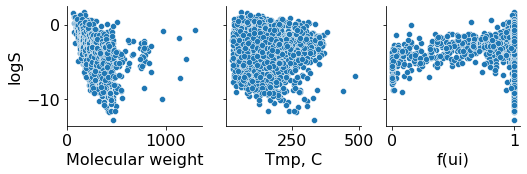

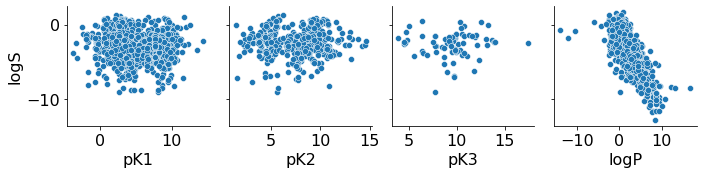

In [45]:
plt.figure(figsize=(2, 25))
sns.pairplot(data=solubility,
                  x_vars= ['Molecular weight', 'Tmp, C','f(ui)'],
                  y_vars=['logS'])
sns.pairplot(data=solubility,
                  x_vars= ['pK1', 'pK2', 'pK3','logP'],
                  y_vars=['logS'])
plt.show()

From the pairplots we can infer the following information:
    
- For the molecules with the molecular weight below 500, logS overally decreases with the increment in molecular wight.
  For the molecules with higher moleculatr weight there is no clear trend in relationship between solubility and molecular     weight.

- There is no clear trend in the relationship between logS and melting temperature (Tmp, C), dissociation constants (pK1,pK2,pK3), the un-ionized fractio (f(ui)).

- There seems to be a strong negative linear relationship between logS and the octanol-water partitioning coefficient logP.

- For the molcules with lower values of polarizability (alpha) there seems to be a linear trend in the relationship with logS.

### Correlation heatmap

Let us quickly look at the correlation heatmap to check the correlations amongst all features.

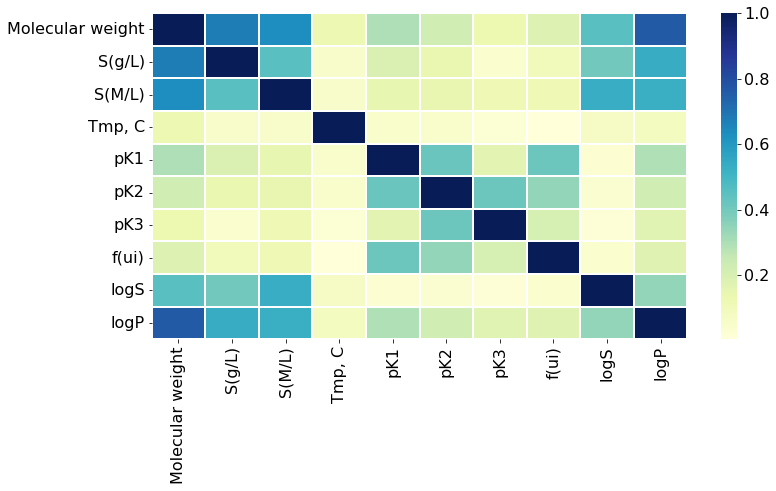

In [46]:
plt.figure(figsize=(10, 5))
corr = solubility.drop(['soluble','Formula','name'],axis=1).apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

We can infer from the correlation matrix plot that solubility is correlated with polarizability (alpha), molecular wight and
logP. We can also infer that alpha is correlated with logP and molecular weight.

Now, let us transform the data and generate new features that we can use for predictive modelling.

## Missing values treatment

In [47]:
data=solubility.copy()

In [48]:
data.isnull().sum()

Formula                0
name                   0
Molecular weight       0
S(g/L)                 0
S(M/L)                 0
Tmp, C               263
pK1                 1232
pK2                 2197
pK3                 2540
f(ui)                  8
logS                   0
logP                   0
soluble                0
dtype: int64

There are missing values for the melting point variable (Tmp, C), the dissociation constant variables(pK1, pK2 and pK3) and
the variable that defines the un-ionization fraction  (f(ui)).

Most of the molecules have only one constant of dissociation. In general, the second and the third steps of the dissociation
happen in lesser extent than in the first step. For this reason, we can drop the variables pK2 and pK3.
Missing pK1 value can mean that it was not measured because the substance has low solubility in water.
Taking into account this assumption, we can do the following transformations:

- We will impute the misssing pK1 values with the maximum pK1 value (high pK1 value mean low constant of dissociation)
- We can create a new feature (pK1_NA) which will indicate wheather the substance had a missing dissociation   constant value.

Additionally, we will impute f(ui) and Tmp, C values with their corresponding median values.

Finally, we will drop the absolute solubility values S(g/L) and S(M/L)

In [49]:
data=data.drop(['S(g/L)','S(M/L)','pK2','pK3'],axis=1)

In [50]:
#data['pK1'].fillna(data['pK1'].median(),inplace=True)
data['f(ui)'].fillna(data['f(ui)'].median(),inplace=True)
data['Tmp, C'].fillna(data['Tmp, C'].median(),inplace=True)

**pK1_NA feature**

In [51]:
condition_pk=(data['pK1'].isna())
data['pK1_NA']=np.where(condition_pk,1,0)

In [52]:
print(data['pK1_NA'].value_counts())

0    1383
1    1232
Name: pK1_NA, dtype: int64


In [53]:
# Impute pK1 with the min value
data['pK1'].fillna(data['pK1'].min(),inplace=True)

**Check for missing values**

In [54]:
data.isnull().sum()

Formula             0
name                0
Molecular weight    0
Tmp, C              0
pK1                 0
f(ui)               0
logS                0
logP                0
soluble             0
pK1_NA              0
dtype: int64

In [55]:
data.shape

(2615, 10)

In [56]:
data_cleaned=data.copy()
data_cleaned.drop(['logS'], axis=1).to_csv('data_cleaned.csv',index=False)

## Additional feature engineering

Now, we will use the information about the chemical structure of molecules available through the variable Formula to
generate new features that can affect aqueous solubility of a molecule.

### Charge

One can assume that charged molcules should have higher solubility in water since water is a polar sovent.
Charged molecules contain regions with positive charge and an equal amount of negatively charged regions in order to
resulting charge to be 0.

The number of charged and uncharged molecules:
0    2430
1     185
Name: charge, dtype: int64


<AxesSubplot:xlabel='charge'>

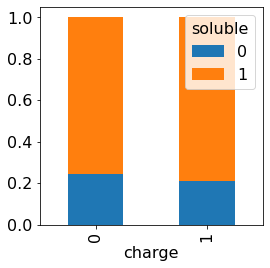

In [57]:
charge=[]

for i in range(2615):
    if data['Formula'][i].find('+')!=-1:
    #if data['Formula'][i].count('+')>1:
        charge.append(1)
    else:
        charge.append(0)
data['charge']=charge
print('The number of charged and uncharged molecules:')
print(data['charge'].value_counts())

charge=pd.crosstab(data['charge'],data['soluble'])
charge.div(charge.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
#,labels = {1:'yes', 0:'no'}

From the barplot we can infer that the proportion of soluble molecules is only slightly higher within charged molecules
as compared to uncharged molecules.

### Long carbon chain

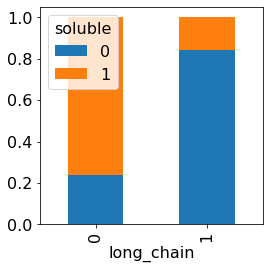

In [58]:
long_chain=[]
for i in range(2615):
    if data['Formula'][i].find('CCCCCCCCCCCCC')!=-1:
        long_chain.append(1)
    else:
        long_chain.append(0)
        
data['long_chain']=long_chain

long_chain=pd.crosstab(data['long_chain'],data['soluble'])
long_chain.div(long_chain.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
plt.show()

We can infer that the proportion of soluble molecules is lower among molecules with molecules containing long carbon chains.

It has been seen that the presence of the hydrogen bond acceptors like (CO, O, F, Cl etc.) has a negative impact on the
substance solubility in water. Let us generate features that reflect the presence of different hydrogen bond acceptors 
in molecules.

### Double bonds

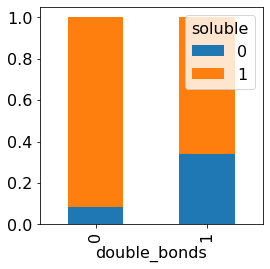

In [59]:
double_bonds=[]

for i in range(2615):
    if data['Formula'][i].count('=')>4:
        double_bonds.append(1)
    else:
        double_bonds.append(0)
        
data['double_bonds']=double_bonds

double_bonds=pd.crosstab(data['double_bonds'],data['soluble'])
double_bonds.div(double_bonds.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
plt.show()

We can infer that among the molecules with 5 and more double bonds, the proportion of soluble molecules is lower as compared 
to molecules with lower amount of double bonds.

### Chlorine

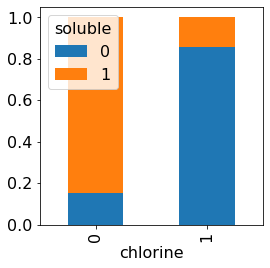

In [60]:
chlorine=[]

for i in range(2615):
    #if data['Smiles'][i].find('Cl')!=-1:
    if data['Formula'][i].count('Cl')>2:
        chlorine.append(1)
    else:
        chlorine.append(0)
        
data['chlorine']=chlorine

chlorine=pd.crosstab(data['chlorine'],data['soluble'])
chlorine.div(chlorine.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
plt.show()

### Fluorine

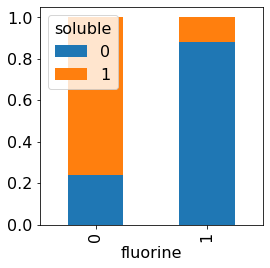

In [61]:
fluorine=[]

for i in range(2615):
    #if data['Smiles'][i].find('F')!=-1:
    if data['Formula'][i].count('F')>3:
        fluorine.append(1)
    else:
        fluorine.append(0)
        
data['fluorine']=fluorine

fluorine=pd.crosstab(data['fluorine'],data['soluble'])
fluorine.div(fluorine.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
plt.show()

### CO

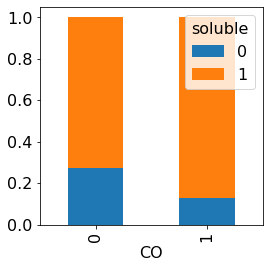

In [62]:
CO=[]

for i in range(2615):
    if data['Formula'][i].count('CO')>0:
        CO.append(1)
    else:
        CO.append(0)
        
data['CO']=CO

CO=pd.crosstab(data['CO'],data['soluble'])
CO.div(CO.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
plt.show()

### NC

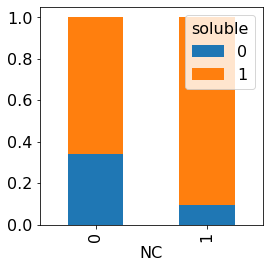

In [63]:
NC=[]

for i in range(2615):
    if data['Formula'][i].count('NC')>0:
        NC.append(1)
    else:
        NC.append(0)
        
data['NC']=NC

NC=pd.crosstab(data['NC'],data['soluble'])
NC.div(NC.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(4,4))
plt.show()

## Logistic Regression

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [286]:
X=data[['Molecular weight','Tmp, C','pK1','logP','f(ui)','charge','fluorine','chlorine','long_chain'
        ,'double_bonds','CO','NC','pK1_NA']]
y=data['soluble']

*Data Standartization*

In [177]:
scaler=StandardScaler()
X_scaled = scaler.fit_transform(X) 

In [178]:
x_train, x_test, y_train,y_test=train_test_split(X_scaled,y,test_size=0.3,random_state=1,stratify=y)

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score

In [179]:
model=LogisticRegression()
model.fit(x_train,y_train)

LogisticRegression()

In [180]:
pred_test=model.predict(x_test)
print('Model test accuracy:',accuracy_score(y_test,pred_test))
print('Test F1 score:',f1_score(y_test,pred_test))

Model test accuracy: 0.9095541401273886
Test F1 score: 0.9412737799834574


### k-fold cross validation

In [181]:
from sklearn.model_selection import StratifiedKFold

In [314]:
# Define function for cross validation
def cv_scores(ml_model,transform=False,rfe=False,df1=X,y=y,n_features=None):
    i = 1
    mean_accuracy=[]
    mean_f1=[]
    
    
    kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
    
    for train_index,test_index in kf.split(df1,y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index],df1.loc[test_index]
        ytr,yvl = y[train_index],y[test_index]
        
  # Feature transformation is needed or not
        if transform==True:
            xtr=scaler.fit_transform(xtr)
            xvl=scaler.transform(xvl)
        else:
            pass
        
        model = ml_model
 
  # FRE is performed or not
        if rfe==True:
            model_rfe=RFE(model,n_features_to_select=n_features)
            model_rfe.fit(xtr,ytr)
            xtr_rfe=model_rfe.transform(xtr)
            xvl_rfe=model_rfe.transform(xvl)
            model.fit(xtr_rfe,ytr)
            pred_test=model.predict(xvl_rfe)
        else:
            model.fit(xtr,ytr)
            pred_test=model.predict(xvl)
            
  # Calculate accuracy and F1 scores         
        score_accuracy=accuracy_score(yvl,pred_test)
        score_f1=f1_score(yvl,pred_test)
        print('accuracy score',score_accuracy)
        print('f1 score', score_f1)
        mean_accuracy.append(score_accuracy)
        mean_f1.append(score_f1)
        i+=1    
    
    print('\n Mean validation accuracy for this model: ',np.asarray(mean_accuracy).mean()) 
    print('\n Mean validation F1 score for this model: ',np.asarray(mean_f1).mean())
    return [np.asarray(mean_accuracy).mean(),np.asarray(mean_f1).mean()]
     

In [315]:
cv_scores(LogisticRegression(random_state=1),transform=True)


1 of kfold 5
accuracy score 0.9216061185468452
f1 score 0.9494451294697903

2 of kfold 5
accuracy score 0.9196940726577438
f1 score 0.9482758620689655

3 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.9423558897243107

4 of kfold 5
accuracy score 0.9101338432122371
f1 score 0.9417596034696406

5 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.9432098765432099

 Mean validation accuracy for this model:  0.9151051625239006

 Mean validation F1 score for this model:  0.9450092722551835


[0.9151051625239006, 0.9450092722551835]

### Feature selection

In [189]:
from sklearn.feature_selection import RFE

Let's rank the features according to their weight in the logit function.

In [233]:
model=LogisticRegression(random_state=1)

rfe=RFE(estimator=model,n_features_to_select=1,step=1)
rfe.fit(x_train,y_train)

ranking_df=pd.DataFrame()
ranking_df['Feature_name']=X.columns
ranking_df['Rank']=rfe.ranking_

ranked=ranking_df.sort_values(by=['Rank'])
print(ranked)

        Feature_name  Rank
3               logP     1
1             Tmp, C     2
12            pK1_NA     3
4              f(ui)     4
9       double_bonds     5
7           chlorine     6
6           fluorine     7
5             charge     8
11                NC     9
0   Molecular weight    10
10                CO    11
8         long_chain    12
2                pK1    13


In [ ]:
We can use the Recursive Feature Elimination teqniue to find with which features we can buikd a Logistic Regression model
with the highest mean validation accuracy and F1 scores.functions 

We can define to 

In [288]:
def select_features(ml_model,transform=False,df1=X,y=y):
    for index in range(1,df1.shape[1]+1):
        print('Selected features: ', index)
        print('*******************************************')
        cv_scores(ml_model, transform=transform,rfe=True,n_features=index)
        print('*******************************************')       

In [289]:
select_features(LogisticRegression(random_state=1),transform=True)

Selected features:  1
*******************************************

1 of kfold 5
accuracy score 0.9235181644359465
f1 score 0.9507389162561576

2 of kfold 5
accuracy score 0.9139579349904398
f1 score 0.9447852760736196

3 of kfold 5
accuracy score 0.8891013384321224
f1 score 0.9287469287469287

4 of kfold 5
accuracy score 0.9101338432122371
f1 score 0.9421894218942188

5 of kfold 5
accuracy score 0.892925430210325
f1 score 0.9306930693069307

 Mean validation accuracy for this model:  0.9059273422562141

 Mean validation F1 score for this model:  0.939430722455571
*******************************************
Selected features:  2
*******************************************

1 of kfold 5
accuracy score 0.9158699808795411
f1 score 0.9458128078817735

2 of kfold 5
accuracy score 0.9082217973231358
f1 score 0.9410319410319411

3 of kfold 5
accuracy score 0.9158699808795411
f1 score 0.9455445544554456

4 of kfold 5
accuracy score 0.8986615678776291
f1 score 0.934487021013597

5 of kfold 5
acc

In [290]:
select=RFE(LogisticRegression(random_state=1),n_features_to_select=9)
select.fit(x_train,y_train)
x_train_rfe=select.transform(x_train)
x_test_rfe=select.transform(x_test)
run_model(LogisticRegression(random_state=1),x_train_rfe,x_test_rfe,y_train,y_test)

Test accuracy score:  0.9146496815286624
Test F1 score:  0.9446738232865399



In [291]:
features=X.columns[select.get_support()]
features

Index(['Tmp, C', 'logP', 'f(ui)', 'charge', 'fluorine', 'chlorine',
       'double_bonds', 'NC', 'pK1_NA'],
      dtype='object')

**Cross-validation for the Logistic Regression model with selected features**

In [292]:
cv_scores(LogisticRegression(random_state=1),transform=True,rfe=True,n_features=9)


1 of kfold 5
accuracy score 0.9254302103250478
f1 score 0.9519112207151664

2 of kfold 5
accuracy score 0.9254302103250478
f1 score 0.9517923362175525

3 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.9423558897243107

4 of kfold 5
accuracy score 0.9139579349904398
f1 score 0.9440993788819876

5 of kfold 5
accuracy score 0.9101338432122371
f1 score 0.9420468557336622

 Mean validation accuracy for this model:  0.9173996175908222

 Mean validation F1 score for this model:  0.946441136254536


## Decision Tree

In [294]:
x_train, x_test, y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

In [293]:
from sklearn import tree

In [299]:
cv_scores(tree.DecisionTreeClassifier(random_state=1))


1 of kfold 5
accuracy score 0.8967495219885278
f1 score 0.9316455696202531

2 of kfold 5
accuracy score 0.9024856596558317
f1 score 0.9361702127659575

3 of kfold 5
accuracy score 0.8833652007648184
f1 score 0.9220945083014049

4 of kfold 5
accuracy score 0.892925430210325
f1 score 0.9285714285714285

5 of kfold 5
accuracy score 0.9024856596558317
f1 score 0.9355246523388117

 Mean validation accuracy for this model:  0.895602294455067

 Mean validation F1 score for this model:  0.930801274319571


### Feature selection

In [296]:
dt=tree.DecisionTreeClassifier(random_state=1).fit(x_train,y_train)

In [297]:
decision_tree = tree.export_graphviz(dt,out_file='tree.dot',feature_names=X.columns,max_depth=2,filled=True)

In [298]:
import pydot
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

Now, let us view the decision tree till depth 2 and find out the features at the root and the first node.

<img src="tree.png" width=500 height=500>

As is clear from the above decision tree we can create a new feature with binned logP with bin edgesaccording to the criteria in the values in the tree nodes.

In [300]:
select_features(tree.DecisionTreeClassifier(random_state=1),transform=False)

Selected features:  1
*******************************************

1 of kfold 5
accuracy score 0.887189292543021
f1 score 0.9257861635220126

2 of kfold 5
accuracy score 0.8738049713193117
f1 score 0.9172932330827067

3 of kfold 5
accuracy score 0.8489483747609943
f1 score 0.8996188055908514

4 of kfold 5
accuracy score 0.8680688336520076
f1 score 0.9121019108280256

5 of kfold 5
accuracy score 0.8432122370936902
f1 score 0.8946015424164525

 Mean validation accuracy for this model:  0.864244741873805

 Mean validation F1 score for this model:  0.9098803310880097
*******************************************
Selected features:  2
*******************************************

1 of kfold 5
accuracy score 0.8986615678776291
f1 score 0.9326556543837359

2 of kfold 5
accuracy score 0.8795411089866156
f1 score 0.9213483146067416

3 of kfold 5
accuracy score 0.8451242829827916
f1 score 0.8970775095298603

4 of kfold 5
accuracy score 0.8718929254302104
f1 score 0.9155107187894074

5 of kfold 5
ac

**Cross-validation for the Decision Tree model with selected features**

In [301]:
cv_scores(tree.DecisionTreeClassifier(random_state=1),transform=False,rfe=True,n_features=12)


1 of kfold 5
accuracy score 0.8967495219885278
f1 score 0.9321608040201005

2 of kfold 5
accuracy score 0.9063097514340345
f1 score 0.9391304347826088

3 of kfold 5
accuracy score 0.8814531548757171
f1 score 0.9213197969543148

4 of kfold 5
accuracy score 0.8967495219885278
f1 score 0.9311224489795918

5 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.9420654911838791

 Mean validation accuracy for this model:  0.8986615678776291

 Mean validation F1 score for this model:  0.9331597951840991


## Random Forest

In [302]:
from sklearn.ensemble import RandomForestClassifier

In [303]:
cv_scores(RandomForestClassifier(random_state=1,max_depth=10))


1 of kfold 5
accuracy score 0.9369024856596558
f1 score 0.9588014981273408

2 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9532019704433498

3 of kfold 5
accuracy score 0.9063097514340345
f1 score 0.9383647798742139

4 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9526184538653367

5 of kfold 5
accuracy score 0.9254302103250478
f1 score 0.9515527950310559

 Mean validation accuracy for this model:  0.9246653919694072

 Mean validation F1 score for this model:  0.9509078994682593


### Feature selection

In [305]:
select_features(RandomForestClassifier(random_state=1,max_depth=10),transform=False)

Selected features:  1
*******************************************

1 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.943069306930693

2 of kfold 5
accuracy score 0.9024856596558317
f1 score 0.9377289377289377

3 of kfold 5
accuracy score 0.8738049713193117
f1 score 0.9177057356608479

4 of kfold 5
accuracy score 0.892925430210325
f1 score 0.9305210918114144

5 of kfold 5
accuracy score 0.875717017208413
f1 score 0.9188514357053684

 Mean validation accuracy for this model:  0.8913957934990441

 Mean validation F1 score for this model:  0.9295753015674524
*******************************************
Selected features:  2
*******************************************

1 of kfold 5
accuracy score 0.9101338432122371
f1 score 0.941469489414695

2 of kfold 5
accuracy score 0.9139579349904398
f1 score 0.9447852760736196

3 of kfold 5
accuracy score 0.8852772466539197
f1 score 0.9253731343283583

4 of kfold 5
accuracy score 0.8986615678776291
f1 score 0.9343246592317225

5 of kfold 5
accu

It looks like we get the best mean validation metrics when we use all the features.

### Tuning the hyperparameters

We will try to improve accuracy by tuning hyperparameters for this model. 

We will tune the max_depth and n_estimators parameters. max_depth decides the maximum depth of the tree and n_estimators decides
the number of trees that will be used in random forest model.

In [317]:
max_depth=list(range(1,30,2))
n_estimators=list(range(1,300,20))
max_accuracy=0


for depth in max_depth:
    for n in n_estimators:

        mean_scores=cv_scores(RandomForestClassifier(random_state=1,max_depth=depth,n_estimators=n))
        
        print('Model hyperparameters:')
        print('max_depth=',depth)
        print('n_estimators=',n)
        print('____________________________') 
        
        
        if mean_scores[0]>max_accuracy:
            max_accuracy=mean_scores[0]
            best_max_depth=depth
            best_n_estimators=n

print('Best parameters:')
print('max_depth=',best_max_depth)
print('n_estimators=',best_n_estimators)


1 of kfold 5
accuracy score 0.7571701720841301
f1 score 0.8618063112078347

2 of kfold 5
accuracy score 0.7571701720841301
f1 score 0.8618063112078347

3 of kfold 5
accuracy score 0.7571701720841301
f1 score 0.8618063112078347

4 of kfold 5
accuracy score 0.7571701720841301
f1 score 0.8618063112078347

5 of kfold 5
accuracy score 0.7571701720841301
f1 score 0.8618063112078347

 Mean validation accuracy for this model:  0.7571701720841301

 Mean validation F1 score for this model:  0.8618063112078346
Model hyperparametrs:
max_depth= 1
n_estimators= 1
____________________________

1 of kfold 5
accuracy score 0.8546845124282982
f1 score 0.9122401847575059

2 of kfold 5
accuracy score 0.8279158699808795
f1 score 0.8979591836734693

3 of kfold 5
accuracy score 0.8393881453154876
f1 score 0.9041095890410958

4 of kfold 5
accuracy score 0.8546845124282982
f1 score 0.9122401847575059

5 of kfold 5
accuracy score 0.8374760994263862
f1 score 0.903078677309008

 Mean validation accuracy for this

accuracy score 0.869980879541109
f1 score 0.9207459207459207

2 of kfold 5
accuracy score 0.8565965583173997
f1 score 0.9134948096885813

3 of kfold 5
accuracy score 0.847036328871893
f1 score 0.9080459770114944

4 of kfold 5
accuracy score 0.8604206500956023
f1 score 0.9154113557358052

5 of kfold 5
accuracy score 0.847036328871893
f1 score 0.908256880733945

 Mean validation accuracy for this model:  0.8562141491395794

 Mean validation F1 score for this model:  0.9131909887831494
Model hyperparametrs:
max_depth= 1
n_estimators= 281
____________________________

1 of kfold 5
accuracy score 0.8776290630975143
f1 score 0.9241706161137441

2 of kfold 5
accuracy score 0.8336520076481836
f1 score 0.889453621346887

3 of kfold 5
accuracy score 0.8336520076481836
f1 score 0.8991888760139051

4 of kfold 5
accuracy score 0.8451242829827916
f1 score 0.9043683589138135

5 of kfold 5
accuracy score 0.8489483747609943
f1 score 0.9086705202312138

 Mean validation accuracy for this model:  0.84780

accuracy score 0.9235181644359465
f1 score 0.9514563106796117

2 of kfold 5
accuracy score 0.9024856596558317
f1 score 0.9389221556886228

3 of kfold 5
accuracy score 0.8948374760994264
f1 score 0.9334945586457072

4 of kfold 5
accuracy score 0.9101338432122371
f1 score 0.9426129426129426

5 of kfold 5
accuracy score 0.8986615678776291
f1 score 0.9360675512665863

 Mean validation accuracy for this model:  0.9059273422562141

 Mean validation F1 score for this model:  0.9405107037786941
Model hyperparametrs:
max_depth= 3
n_estimators= 261
____________________________

1 of kfold 5
accuracy score 0.9235181644359465
f1 score 0.9514563106796117

2 of kfold 5
accuracy score 0.904397705544933
f1 score 0.9400479616306956

3 of kfold 5
accuracy score 0.8910133843212237
f1 score 0.930909090909091

4 of kfold 5
accuracy score 0.9101338432122371
f1 score 0.9426129426129426

5 of kfold 5
accuracy score 0.8986615678776291
f1 score 0.9360675512665863

 Mean validation accuracy for this model:  0.90

accuracy score 0.9311663479923518
f1 score 0.9557739557739557

2 of kfold 5
accuracy score 0.9196940726577438
f1 score 0.9487804878048781

3 of kfold 5
accuracy score 0.8967495219885278
f1 score 0.9330024813895782

4 of kfold 5
accuracy score 0.9158699808795411
f1 score 0.9456790123456789

5 of kfold 5
accuracy score 0.9139579349904398
f1 score 0.9447852760736196

 Mean validation accuracy for this model:  0.9154875717017209

 Mean validation F1 score for this model:  0.9456042426775421
Model hyperparametrs:
max_depth= 5
n_estimators= 241
____________________________

1 of kfold 5
accuracy score 0.9311663479923518
f1 score 0.9556650246305419

2 of kfold 5
accuracy score 0.9216061185468452
f1 score 0.9499389499389499

3 of kfold 5
accuracy score 0.9005736137667304
f1 score 0.935483870967742

4 of kfold 5
accuracy score 0.9158699808795411
f1 score 0.9456790123456789

5 of kfold 5
accuracy score 0.9139579349904398
f1 score 0.9447852760736196

 Mean validation accuracy for this model:  0.9

accuracy score 0.9330783938814532
f1 score 0.956629491945477

2 of kfold 5
accuracy score 0.9254302103250478
f1 score 0.9521472392638037

3 of kfold 5
accuracy score 0.9101338432122371
f1 score 0.9411764705882353

4 of kfold 5
accuracy score 0.9196940726577438
f1 score 0.9478908188585607

5 of kfold 5
accuracy score 0.9196940726577438
f1 score 0.9480198019801979

 Mean validation accuracy for this model:  0.9216061185468452

 Mean validation F1 score for this model:  0.949172764527255
Model hyperparametrs:
max_depth= 7
n_estimators= 221
____________________________

1 of kfold 5
accuracy score 0.9349904397705545
f1 score 0.957920792079208

2 of kfold 5
accuracy score 0.9254302103250478
f1 score 0.9521472392638037

3 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.9423558897243107

4 of kfold 5
accuracy score 0.9196940726577438
f1 score 0.9478908188585607

5 of kfold 5
accuracy score 0.9196940726577438
f1 score 0.9480198019801979

 Mean validation accuracy for this model:  0.922

accuracy score 0.9254302103250478
f1 score 0.9520295202952029

3 of kfold 5
accuracy score 0.9139579349904398
f1 score 0.9435382685069008

4 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9526184538653367

5 of kfold 5
accuracy score 0.9330783938814532
f1 score 0.9567367119901112

 Mean validation accuracy for this model:  0.9261950286806883

 Mean validation F1 score for this model:  0.9520736998424015
Model hyperparametrs:
max_depth= 9
n_estimators= 201
____________________________

1 of kfold 5
accuracy score 0.9349904397705545
f1 score 0.957920792079208

2 of kfold 5
accuracy score 0.9254302103250478
f1 score 0.9520295202952029

3 of kfold 5
accuracy score 0.9139579349904398
f1 score 0.9436795994993742

4 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9526184538653367

5 of kfold 5
accuracy score 0.9330783938814532
f1 score 0.9567367119901112

 Mean validation accuracy for this model:  0.9269598470363288

 Mean validation F1 score for this model:  0.95259701554584

accuracy score 0.9254302103250478
f1 score 0.9519112207151664

3 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.9423558897243107

4 of kfold 5
accuracy score 0.9235181644359465
f1 score 0.9501246882793017

5 of kfold 5
accuracy score 0.9216061185468452
f1 score 0.9490683229813663

 Mean validation accuracy for this model:  0.9227533460803059

 Mean validation F1 score for this model:  0.9497368004594321
Model hyperparametrs:
max_depth= 11
n_estimators= 181
____________________________

1 of kfold 5
accuracy score 0.9349904397705545
f1 score 0.9578163771712158

2 of kfold 5
accuracy score 0.9235181644359465
f1 score 0.9506172839506173

3 of kfold 5
accuracy score 0.9139579349904398
f1 score 0.9435382685069008

4 of kfold 5
accuracy score 0.9235181644359465
f1 score 0.9501246882793017

5 of kfold 5
accuracy score 0.9216061185468452
f1 score 0.9490683229813663

 Mean validation accuracy for this model:  0.9235181644359465

 Mean validation F1 score for this model:  0.950232988177

accuracy score 0.9216061185468452
f1 score 0.9494451294697903

3 of kfold 5
accuracy score 0.9063097514340345
f1 score 0.9385194479297365

4 of kfold 5
accuracy score 0.9254302103250478
f1 score 0.951310861423221

5 of kfold 5
accuracy score 0.9254302103250478
f1 score 0.9516728624535317

 Mean validation accuracy for this model:  0.9231357552581262

 Mean validation F1 score for this model:  0.9499909024912808
Model hyperparametrs:
max_depth= 13
n_estimators= 161
____________________________

1 of kfold 5
accuracy score 0.9349904397705545
f1 score 0.9578163771712158

2 of kfold 5
accuracy score 0.9196940726577438
f1 score 0.9482758620689655

3 of kfold 5
accuracy score 0.9063097514340345
f1 score 0.9383647798742139

4 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9525

5 of kfold 5
accuracy score 0.9254302103250478
f1 score 0.9516728624535317

 Mean validation accuracy for this model:  0.9227533460803059

 Mean validation F1 score for this model:  0.9497259763135855
Model hy

accuracy score 0.904397705544933
f1 score 0.9371859296482412

4 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9525

5 of kfold 5
accuracy score 0.9139579349904398
f1 score 0.9439601494396015

 Mean validation accuracy for this model:  0.9208413001912046

 Mean validation F1 score for this model:  0.948439467702696
Model hyperparametrs:
max_depth= 15
n_estimators= 141
____________________________

1 of kfold 5
accuracy score 0.9330783938814532
f1 score 0.9564134495641345

2 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9532019704433498

3 of kfold 5
accuracy score 0.9082217973231358
f1 score 0.9396984924623116

4 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9523809523809523

5 of kfold 5
accuracy score 0.9177820267686424
f1 score 0.9464508094645081

 Mean validation accuracy for this model:  0.9227533460803059

 Mean validation F1 score for this model:  0.9496291348630514
Model hyperparametrs:
max_depth= 15
n_estimators= 161
____________________________

1

accuracy score 0.9273422562141491
f1 score 0.9525

5 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.9426433915211971

 Mean validation accuracy for this model:  0.9208413001912046

 Mean validation F1 score for this model:  0.9484643703383228
Model hyperparametrs:
max_depth= 17
n_estimators= 121
____________________________

1 of kfold 5
accuracy score 0.9369024856596558
f1 score 0.9592088998763907

2 of kfold 5
accuracy score 0.9235181644359465
f1 score 0.9507389162561576

3 of kfold 5
accuracy score 0.9063097514340345
f1 score 0.9383647798742139

4 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9525

5 of kfold 5
accuracy score 0.9158699808795411
f1 score 0.945273631840796

 Mean validation accuracy for this model:  0.9219885277246653

 Mean validation F1 score for this model:  0.9492172455695117
Model hyperparametrs:
max_depth= 17
n_estimators= 141
____________________________

1 of kfold 5
accuracy score 0.9349904397705545
f1 score 0.9578163771712158

2 of kfold 5

accuracy score 0.9330783938814532
f1 score 0.9564134495641345

2 of kfold 5
accuracy score 0.9235181644359465
f1 score 0.9508599508599509

3 of kfold 5
accuracy score 0.9024856596558317
f1 score 0.9361702127659575

4 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9525

5 of kfold 5
accuracy score 0.9139579349904398
f1 score 0.9438202247191012

 Mean validation accuracy for this model:  0.920076481835564

 Mean validation F1 score for this model:  0.9479527675818289
Model hyperparametrs:
max_depth= 19
n_estimators= 121
____________________________

1 of kfold 5
accuracy score 0.9330783938814532
f1 score 0.9564134495641345

2 of kfold 5
accuracy score 0.9235181644359465
f1 score 0.9508599508599509

3 of kfold 5
accuracy score 0.9024856596558317
f1 score 0.9361702127659575

4 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9525

5 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.9426433915211971

 Mean validation accuracy for this model:  0.9196940726577438

 Mean 

accuracy score 0.9235181644359465
f1 score 0.9507389162561576

3 of kfold 5
accuracy score 0.9005736137667304
f1 score 0.9349999999999999

4 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9525

5 of kfold 5
accuracy score 0.9139579349904398
f1 score 0.9439601494396015

 Mean validation accuracy for this model:  0.920076481835564

 Mean validation F1 score for this model:  0.948003088573395
Model hyperparametrs:
max_depth= 21
n_estimators= 101
____________________________

1 of kfold 5
accuracy score 0.9330783938814532
f1 score 0.9564134495641345

2 of kfold 5
accuracy score 0.9254302103250478
f1 score 0.9520295202952029

3 of kfold 5
accuracy score 0.904397705544933
f1 score 0.93734335839599

4 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9525

5 of kfold 5
accuracy score 0.9139579349904398
f1 score 0.9438202247191012

 Mean validation accuracy for this model:  0.9208413001912046

 Mean validation F1 score for this model:  0.9484213105948858
Model hyperparametrs:
ma

accuracy score 0.8986615678776291
f1 score 0.9336670838548186

4 of kfold 5
accuracy score 0.9292543021032504
f1 score 0.9536921151439299

5 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.9426433915211971

 Mean validation accuracy for this model:  0.9204588910133843

 Mean validation F1 score for this model:  0.9482041876269023
Model hyperparametrs:
max_depth= 23
n_estimators= 81
____________________________

1 of kfold 5
accuracy score 0.9349904397705545
f1 score 0.9578163771712158

2 of kfold 5
accuracy score 0.9235181644359465
f1 score 0.9507389162561576

3 of kfold 5
accuracy score 0.9005736137667304
f1 score 0.9349999999999999

4 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9525

5 of kfold 5
accuracy score 0.9139579349904398
f1 score 0.9439601494396015

 Mean validation accuracy for this model:  0.920076481835564

 Mean validation F1 score for this model:  0.948003088573395
Model hyperparametrs:
max_depth= 23
n_estimators= 101
____________________________

1 

accuracy score 0.9292543021032504
f1 score 0.9535759096612296

5 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.9426433915211971

 Mean validation accuracy for this model:  0.920076481835564

 Mean validation F1 score for this model:  0.9478887276217567
Model hyperparametrs:
max_depth= 25
n_estimators= 61
____________________________

1 of kfold 5
accuracy score 0.9349904397705545
f1 score 0.9578163771712158

2 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9532019704433498

3 of kfold 5
accuracy score 0.8986615678776291
f1 score 0.9336670838548186

4 of kfold 5
accuracy score 0.9292543021032504
f1 score 0.9536921151439299

5 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.9426433915211971

 Mean validation accuracy for this model:  0.9204588910133843

 Mean validation F1 score for this model:  0.9482041876269023
Model hyperparametrs:
max_depth= 25
n_estimators= 81
____________________________

1 of kfold 5
accuracy score 0.9349904397705545
f1 score 0.95781637

accuracy score 0.9120458891013384
f1 score 0.9425

 Mean validation accuracy for this model:  0.918546845124283

 Mean validation F1 score for this model:  0.9468631432034404
Model hyperparametrs:
max_depth= 27
n_estimators= 41
____________________________

1 of kfold 5
accuracy score 0.9330783938814532
f1 score 0.9565217391304348

2 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9532019704433498

3 of kfold 5
accuracy score 0.8986615678776291
f1 score 0.9335006273525722

4 of kfold 5
accuracy score 0.9292543021032504
f1 score 0.9535759096612296

5 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.9426433915211971

 Mean validation accuracy for this model:  0.920076481835564

 Mean validation F1 score for this model:  0.9478887276217567
Model hyperparametrs:
max_depth= 27
n_estimators= 61
____________________________

1 of kfold 5
accuracy score 0.9349904397705545
f1 score 0.9578163771712158

2 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9532019704433498

3 o

accuracy score 0.9235181644359465
f1 score 0.9507389162561576

3 of kfold 5
accuracy score 0.8967495219885278
f1 score 0.9321608040201005

4 of kfold 5
accuracy score 0.9292543021032504
f1 score 0.9536921151439299

5 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.9425

 Mean validation accuracy for this model:  0.918546845124283

 Mean validation F1 score for this model:  0.9468631432034404
Model hyperparametrs:
max_depth= 29
n_estimators= 41
____________________________

1 of kfold 5
accuracy score 0.9330783938814532
f1 score 0.9565217391304348

2 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9532019704433498

3 of kfold 5
accuracy score 0.8986615678776291
f1 score 0.9335006273525722

4 of kfold 5
accuracy score 0.9292543021032504
f1 score 0.9535759096612296

5 of kfold 5
accuracy score 0.9120458891013384
f1 score 0.9426433915211971

 Mean validation accuracy for this model:  0.920076481835564

 Mean validation F1 score for this model:  0.9478887276217567
Model hype

The optimized hyperparameters are:

max_depth=9
n_estimators=261
    
Now, let's build the model with these optimized values.

In [318]:
cv_scores(RandomForestClassifier(random_state=1,max_depth=9,n_estimators=261))


1 of kfold 5
accuracy score 0.9369024856596558
f1 score 0.9591078066914498

2 of kfold 5
accuracy score 0.9254302103250478
f1 score 0.9520295202952029

3 of kfold 5
accuracy score 0.9139579349904398
f1 score 0.9436795994993742

4 of kfold 5
accuracy score 0.9273422562141491
f1 score 0.9526184538653367

5 of kfold 5
accuracy score 0.9330783938814532
f1 score 0.9567367119901112

 Mean validation accuracy for this model:  0.9273422562141491

 Mean validation F1 score for this model:  0.9528344184682951


[0.9273422562141491, 0.9528344184682951]

Let's also check the accuracy of this model on a test data:

In [319]:
model=RandomForestClassifier(random_state=1,max_depth=9,n_estimators=261)
model.fit(x_train,y_train)
pred_test=model.predict(x_test)
print('Model test accuracy:',accuracy_score(y_test,pred_test))
print('Test F1 score:',f1_score(y_test,pred_test))

Model test accuracy: 0.9273885350318471
Test F1 score: 0.9525395503746877


The model shows quite good accuracy on a test data too (similar to the mean value of validation accuracy that we obtained in 
                                                       cross-validation).

Let us find the feature importance now, i.e. which features are the most important for this problem.

<AxesSubplot:>

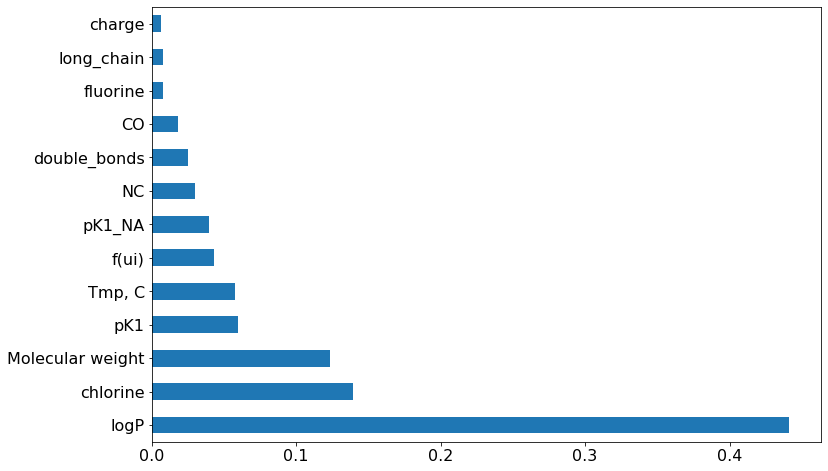

In [321]:
model=RandomForestClassifier(random_state=1,max_depth=9,n_estimators=261).fit(x_train,y_train)
importances=pd.Series(model.feature_importances_,index=X.columns)
importances.sort_values(axis=0, ascending=False).plot(kind='barh',figsize=(12,8))

The most important features are octane-water partinioning coefficient, the presence of chlorine
in the structure and polarizability (alpha) so feature engineering heped us to predict the target variable.

## AdaBoost

In [322]:
from sklearn.ensemble import AdaBoostClassifier

In [323]:
cv_scores(AdaBoostClassifier(random_state=1,base_estimator=RandomForestClassifier(random_state=1,max_depth=9)))


1 of kfold 5
accuracy score 0.9311663479923518
f1 score 0.955223880597015

2 of kfold 5
accuracy score 0.9196940726577438
f1 score 0.9484029484029485

3 of kfold 5
accuracy score 0.904397705544933
f1 score 0.93734335839599

4 of kfold 5
accuracy score 0.9196940726577438
f1 score 0.9477611940298508

5 of kfold 5
accuracy score 0.9158699808795411
f1 score 0.9455445544554456

 Mean validation accuracy for this model:  0.9181644359464627

 Mean validation F1 score for this model:  0.9468551871762501


[0.9181644359464627, 0.9468551871762501]

## XGBOOST

XGBOOST is a fast and efficient algorithm.
XGBOOST works only with numeric variables. Let's have a look at the parameters we are going to use in our model.

- n_estimator: This specifies the number of trees for the model.
- max_depth: We can specify maximum depth of a tree using this parameter.

In [99]:
from xgboost import XGBClassifier

In [324]:
cv_scores(XGBClassifier(random_state=1,max_depth=9))


1 of kfold 5
accuracy score 0.9235181644359465
f1 score 0.95

2 of kfold 5
accuracy score 0.9254302103250478
f1 score 0.9515527950310559

3 of kfold 5
accuracy score 0.9082217973231358
f1 score 0.9396984924623116

4 of kfold 5
accuracy score 0.9196940726577438
f1 score 0.9476309226932668

5 of kfold 5
accuracy score 0.904397705544933
f1 score 0.93734335839599

 Mean validation accuracy for this model:  0.9162523900573614

 Mean validation F1 score for this model:  0.9452451137165248


[0.9162523900573614, 0.9452451137165248]

## Stacking: Logistic regression + Decision tree + kNeigbors

In [102]:
x_train, x_test, y_train,y_test=train_test_split(X_scaled,y,test_size=0.3,random_state=1,stratify=y)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

def model_predictions(model,x_train,y_train,x_test):
     
    #model fit
    model.fit(x_train,y_train)
    
    #storing predictions for train and test
    train_pred=model.predict(x_train)
    test_pred=model.predict(x_test)
    
    return(train_pred,test_pred)


# Model 1
DT=tree.DecisionTreeClassifier(random_state=1)
M1_train,M1_test=model_predictions(DT,x_train,y_train,x_test)

# Feature scaling
scaler=StandardScaler()
scaler.fit(x_train) 

x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)             
              

# Model 2
LR=LogisticRegression(random_state=1)
M2_train,M2_test=model_predictions(LR,x_train,y_train,x_test) 
              
# Model 3
knn=KNeighborsClassifier()
M3_train,M3_test=model_predictions(knn,x_train,y_train,x_test) 

#### Stacking ###
              
# New predictions dataframes
train_prediction= {'DT':M1_train,
                          'LR':M2_train,
                          'knn':M3_train}  
train_predictions=pd.DataFrame(train_prediction)

test_prediction= {'DT':M1_test,
                          'LR':M2_test,
                          'knn':M3_test}  
test_predictions=pd.DataFrame(test_prediction)

#Stacker model
model=LogisticRegression()
model.fit(train_predictions,y_train)
model.score(test_predictions,y_test)

0.8980891719745223

## Model comparison

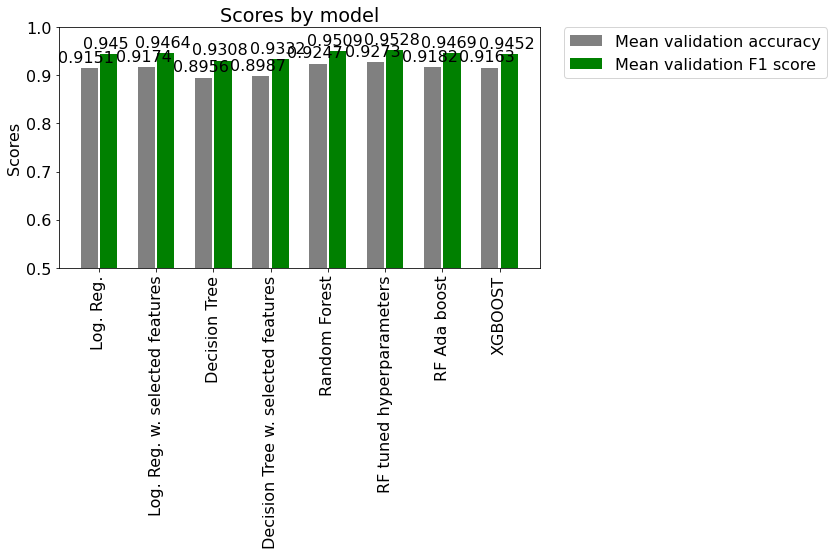

In [351]:
labels = ['Log. Reg.','Log. Reg. w. selected features','Decision Tree', 'Decision Tree w. selected features',
          'Random Forest','RF tuned hyperparameters','RF Ada boost','XGBOOST']
mean_validation_accuracy = [0.9151,0.9174,0.8956,0.8987,0.9247,0.9273,0.9182,0.9163]
mean_validation_F1_score = [0.9450,0.9464,0.9308,0.9332,0.9509,0.9528,0.9469,0.9452]

x = np.array([0,1,2,3,4,5,6,7])  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - 0.17,mean_validation_accuracy, width, label='Mean validation accuracy',color='grey')
rects2 = ax.bar(x + 0.17,mean_validation_F1_score, width, label='Mean validation F1 score',color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by model')
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(ymin=0.5, ymax=1)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x()+0.1 , height),
                    xytext=(0, 3),  # 4 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

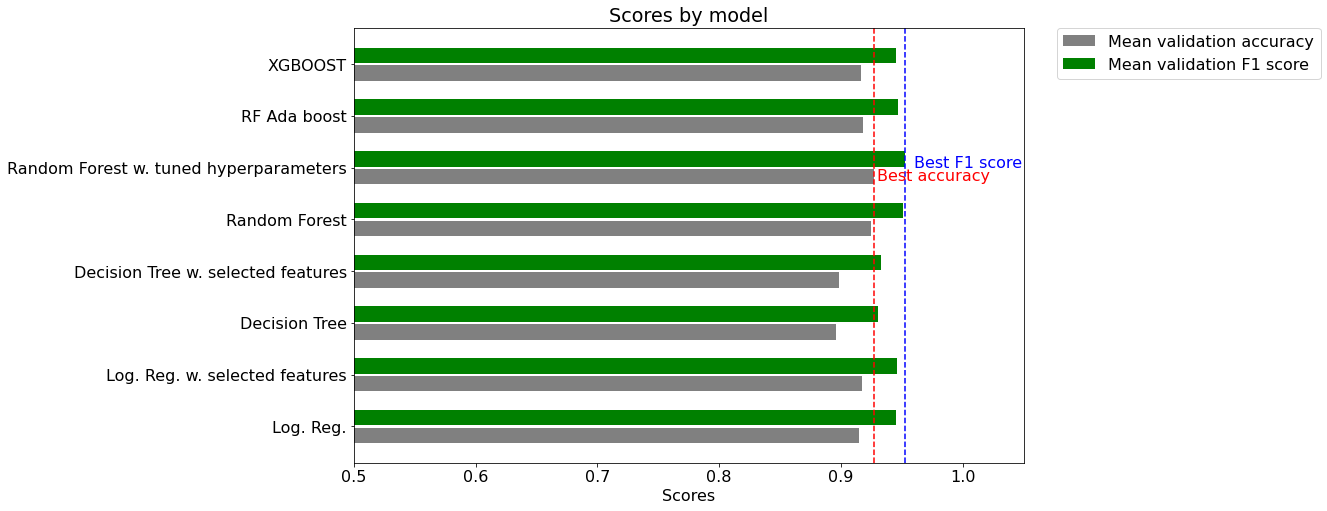

In [387]:
labels = ['Log. Reg.','Log. Reg. w. selected features','Decision Tree', 'Decision Tree w. selected features',
          'Random Forest','Random Forest w. tuned hyperparameters','RF Ada boost','XGBOOST']
mean_validation_accuracy = [0.9151,0.9174,0.8956,0.8987,0.9247,0.9273,0.9182,0.9163]
mean_validation_F1_score = [0.9450,0.9464,0.9308,0.9332,0.9509,0.9528,0.9469,0.9452]

x = np.array([0,1,2,3,4,5,6,7])  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.barh(x - 0.17,mean_validation_accuracy,width,label='Mean validation accuracy',color='grey')
rects2 = ax.barh(x + 0.17,mean_validation_F1_score,width, label='Mean validation F1 score',color='green')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Scores')
ax.set_title('Scores by model')
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(xmin=0.5, xmax=1.05)
ax.axvline(0.9273, ls='--', color='r')
plt.text(0.93, 4.75, 'Best accuracy',color='r')
ax.axvline(0.9528, ls='--', color='b')
plt.text(0.96, 5, 'Best F1 score',color='b')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x()+0.1 , height),
                    xytext=(0, 3),  # 4 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()

The winner is the Random Forest model. With this model we achieved the highest mean validation accuracy and F1 score
predicting molecule solubility.

## Regression

### Linear Regression

Now we can try to use different regression models to predict the actual values of solubility in water (logS).

In [106]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [107]:
X=data[['Molecular weight','Tmp, C','pK1','logP','f(ui)','charge','fluorine','chlorine','long_chain','double_bonds','CO','NC','pK1_NA']]
y=data['logS']


In [108]:
x_train, x_test, y_train,y_test=train_test_split(X_scaled,y,test_size=0.3,random_state=1)

In [109]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)

LinearRegression()

In [110]:
pred=linreg.predict(x_test)

In [111]:
print('RMSE:',np.sqrt(mean_squared_error(pred,y_test)))

RMSE: 0.921107775978968


### Decision Tree 

In [112]:
x_train, x_test, y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)
dt=tree.DecisionTreeRegressor()
dt.fit(x_train, y_train)


DecisionTreeRegressor()

In [113]:
pred=dt.predict(x_test)
print('RMSE:',np.sqrt(mean_squared_error(pred,y_test)))

RMSE: 1.2017964982144398


### Random Forest

In [114]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()
rf.fit(x_train, y_train)

RandomForestRegressor()

In [115]:
pred=rf.predict(x_test)
print('RMSE:',np.sqrt(mean_squared_error(pred,y_test)))

RMSE: 0.8300543459920144


In [116]:
grid_search=GridSearchCV(RandomForestRegressor(random_state=1),paramgrid)
# Fit the grid search model
grid_search.fit(x_train,y_train)
grid_search.best_estimator_

RandomForestRegressor(max_depth=13, n_estimators=261, random_state=1)

In [117]:
rf_tuned=RandomForestRegressor(max_depth=23, n_estimators=281, random_state=1)
rf_tuned.fit(x_train, y_train)

RandomForestRegressor(max_depth=23, n_estimators=281, random_state=1)

In [118]:
pred=rf_tuned.predict(x_test)
print('RMSE:',np.sqrt(mean_squared_error(pred,y_test)))

RMSE: 0.8267559380861461


### XGBoost

In [119]:
from xgboost import XGBRegressor
xgb=XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [120]:
pred=xgb.predict(x_test)
print('RMSE:',np.sqrt(mean_squared_error(pred,y_test)))

RMSE: 0.8529926886472698


In [121]:
grid_search=GridSearchCV(XGBRegressor(random_state=1),paramgrid)
# Fit the grid search model
grid_search.fit(x_train,y_train)
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=41, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=1, ...)

In [122]:
xgb_tuned=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             monotone_constraints='()', n_estimators=81, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=1)
xgb_tuned.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=81, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=1, ...)

In [123]:
pred=xgb_tuned.predict(x_test)
print('RMSE:',np.sqrt(mean_squared_error(pred,y_test)))

RMSE: 0.8509595447091399


Considering the RMSE values obtained on the test data, we can conclude that the best model for the problem of predicting
solubility values based on other physiochemical properties of organic molecules is the tuned Random Forest Regressor model.